## Classifying human faces using convolutional neural networks (ConvNet's)

The objective of this workshop is to introduce the classic convolutional neuronal network architecture (ConvNet) LeNet-5 to the attendees using python, tensor-flow and sci-kit learn. Attendees will learn the basics and how to build a ConvNet classifying whether or not an image has a human face.

Workshop points:

* Brief introduction to the Fundamentals of the Neuronal Convolutional Network using the LeNet-5 Architecture
* Preparation of data using numpy and sklearn
* Building a ConvNet with Tensor-flow
* Use of ConvNet to detect whether or not an image has a human face
* Conclusions

In [11]:
# Library and dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.misc
import glob
import cv2
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import Markdown, display
from scipy import signal
import time
import random

%matplotlib inline

### Matrix convolution

It is an operation between two matrices where the matrix A is applied another matrix B can also be called filter or kernel, to give an idea of what this operation does, the next cells show an example with the matrices A = x and B = W The ConvNets networks are characterized by making intensive use of convolutions for the automatic extraction of characteristics of the images, later this notebook shows the network architecture LeNet-5 that uses layers of convolution and sub-sampling.

In [12]:
x = np.array([
    [ 8, 8, 8, 8],
    [ 8, 8, 8, 8],
    [ 8, 8, 8, 8],
    [ 8, 8, 8, 8]
])

W = np.array([
    [2, 1],
    [0, 3]
])

### Valid padding
$$ x = \begin{bmatrix}
    8 & 8 & 8 & 8\\
    8 & 8 & 8 & 8\\
    8 & 8 & 8 & 8\\
    8 & 8 & 8 & 8
\end{bmatrix} \;\;\; W = \begin{bmatrix}
    2 & 1\\
    0 & 3
\end{bmatrix}\;\;\;  x * W (convolution) =\begin{bmatrix}
    48_{1,1} & 48_{1,2} & 48_{1,3}\\
    48_{2,1} & 48_{2,2} & 48_{2,3}\\
    48_{3,1} & 48_{3,2} & 48_{3,3}
\end{bmatrix}$$

$$ (x * W)_{1,1} = \begin{bmatrix}
    8 * 2& 8 * 1\\
    8 * 0& 8 * 3
\end{bmatrix} \;\;\; => \begin{bmatrix}
    16 & 8\\
    0  & 24
\end{bmatrix}\;\;\; => (unroll)\begin{bmatrix}
    16 + 8 + 0 + 24
\end{bmatrix}\;\;\;    => \begin{bmatrix}
    48
\end{bmatrix}_{1,1}$$

In [13]:
signal.convolve2d(x, W, mode='valid')

array([[48, 48, 48],
       [48, 48, 48],
       [48, 48, 48]])

### Same (with padding) applies mirror to W only when mode is same
$$ x = \begin{bmatrix}
    0 & 0 & 0 & 0 & 0 \\
    0 & 8 & 8 & 8 & 8 \\
    0 & 8 & 8 & 8 & 8 \\
    0 & 8 & 8 & 8 & 8 \\
    0 & 8 & 8 & 8 & 8 \\
\end{bmatrix} \;\;\; mirror(W) = W' = \begin{bmatrix}
    3 & 0\\
    1 & 2
\end{bmatrix}\;\;\;  x * W' (convolution) =\begin{bmatrix}
    16_{1,1} & 24_{1,2} & 24_{1,3} & 24_{1,4}\\
    16_{2,1} & 48_{2,2} & 48_{2,3} & 48_{2,4}\\
    16_{3,1} & 48_{3,2} & 48_{3,3} & 48_{3,4}\\
    16_{4,1} & 48_{4,2} & 48_{4,3} & 48_{4,4}
\end{bmatrix}$$

$$ (x * W')_{1,1} = \begin{bmatrix}
    0 * 3& 0 * 0\\
    0 * 1& 8 * 2
\end{bmatrix} \;\;\; => \begin{bmatrix}
    0 & 0\\
    0  & 16
\end{bmatrix}\;\;\; => (unroll)\begin{bmatrix}
    0 + 0 + 0 + 16
\end{bmatrix}\;\;\;    => \begin{bmatrix}
    16
\end{bmatrix}_{1,1}$$

$$ (x * W')_{1,2} = \begin{bmatrix}
    0 * 3& 0 * 0\\
    8 * 1& 8 * 2
\end{bmatrix} \;\;\; => \begin{bmatrix}
    0 & 0\\
    8  & 16
\end{bmatrix}\;\;\; => (unroll)\begin{bmatrix}
    0 + 0 + 8 + 16
\end{bmatrix}\;\;\;    => \begin{bmatrix}
    24
\end{bmatrix}_{1,2}$$

$$ (x * W')_{2,1} = \begin{bmatrix}
    8 * 3& 8 * 0\\
    8 * 1& 8 * 2
\end{bmatrix} \;\;\; => \begin{bmatrix}
    24 & 0\\
    8  & 16
\end{bmatrix}\;\;\; => (unroll)\begin{bmatrix}
    24 + 0 + 8 + 16
\end{bmatrix}\;\;\;    => \begin{bmatrix}
    48
\end{bmatrix}_{2,1}$$

In [14]:
signal.convolve2d(x, W, mode="same")

array([[16, 24, 24, 24],
       [16, 48, 48, 48],
       [16, 48, 48, 48],
       [16, 48, 48, 48]])

##### The next cells show how to use convolutions on an image with a kernel known as Sobel

In [15]:
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = np.float)
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype = np.float)

image = cv2.imread('./data/faces/no_faces/n02086240_936.jpg', 0)
print(sobel_x, "Sobel kernel X\n")
print(sobel_y, "Sobel kernel Y\n")

[[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]] Sobel kernel X

[[ 1.  2.  1.]
 [ 0.  0.  0.]
 [-1. -2. -1.]] Sobel kernel Y



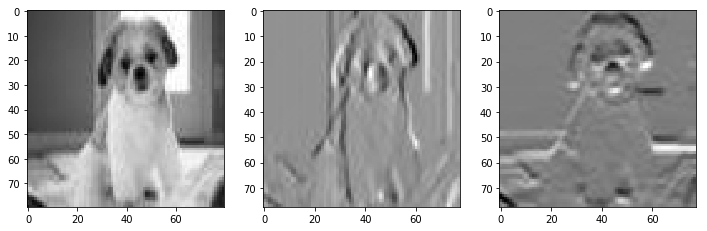

In [16]:
image_sobel_x = signal.convolve2d(image, sobel_x, mode='valid')
image_sobel_y = signal.convolve2d(image, sobel_y, mode='valid')
fig,((a,b,c)) = plt.subplots(1,3, figsize=(12,12))

a.imshow(image, cmap="gray")
b.imshow(image_sobel_x, cmap="gray")
c.imshow(image_sobel_y, cmap="gray")

#### Applying convolutions with random kernels

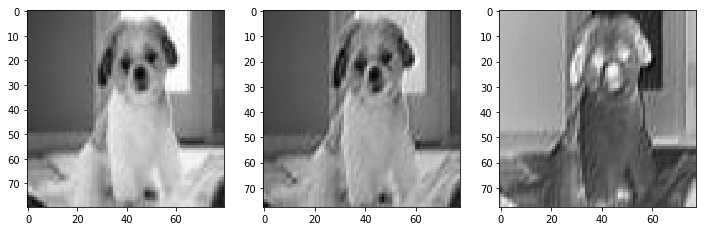

In [17]:
W1 = np.random.randint(-100, 100, (3,3))
W2 = np.random.randint(-2, 2, (3,3))
image_rand_w1_x = signal.convolve2d(image, W1, mode='valid')
image_rand_w2_x = signal.convolve2d(image, W2, mode='valid')
fig,((a,b,c)) = plt.subplots(1,3, figsize=(12,12))

a.imshow(image, cmap="gray")
b.imshow(image_rand_w1_x, cmap="gray")
c.imshow(image_rand_w2_x, cmap="gray")

#### Implementation of convolution in tensorflow

In [18]:
tf.reset_default_graph()
_x = np.array([image[:, :, np.newaxis].astype(np.float32)])
x = tf.get_variable('X', initializer=_x)
W = tf.get_variable('weights', [5, 5, 1, 16], initializer=tf.truncated_normal_initializer(stddev=5e-2, dtype=tf.float32), dtype=tf.float32)
conv1 = tf.nn.conv2d(x, W, [1, 1, 1, 1], 'SAME')
result = None

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    result = sess.run(conv1)
    

In [19]:
result.shape

(1, 80, 80, 16)

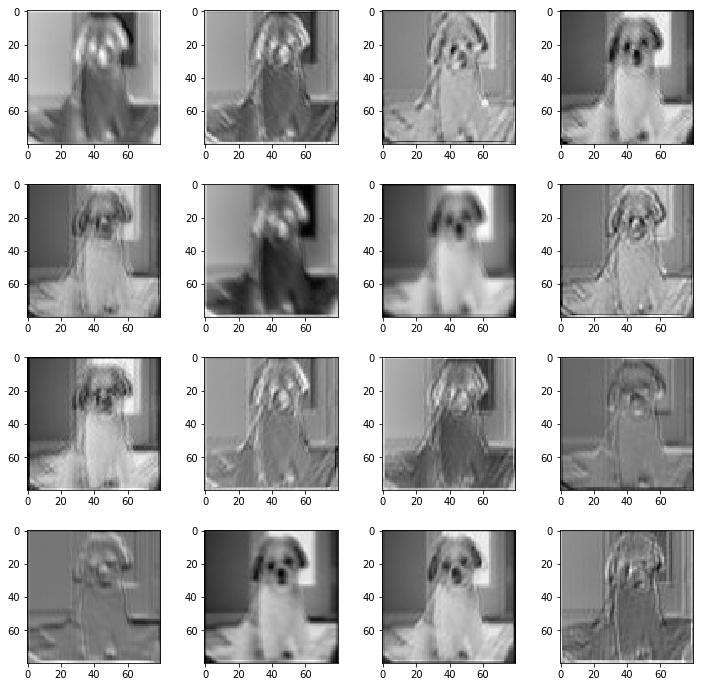

In [20]:
fig, draws = plt.subplots(4,4, figsize=(12,12))
draws = draws.reshape(-1)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for idx in range(result.shape[-1]):    
    draws[idx].imshow(result[0, :, :, idx], cmap="gray")

#### Submuestreo de imagenes (MaxPooling)

The ConvNets also use subsampling layers to reduce the feature space and also help to generalize the resulting model.

The following cells show how to use subsampling using an example code from [stackoverflow] (https://stackoverflow.com/questions/42463172/how-to-perform-max-mean-pooling-on-a-2d-array-using-numpy) on a matrix.

### Max Pooling

$$ x = \begin{bmatrix}
 304 & -779 & -424 &  287 \\
-385 &  617 & -665 &  738 \\
 497 &  974 &  390 & -678 \\
-669 & -854 &  661 & -919 
\end{bmatrix} \;\;\; Maxpool(x, kernelSize: 2, slide: 2) =\begin{bmatrix}
    617 & 738\\
    974 & 661
\end{bmatrix}$$

In [21]:
x = np.array(
    [[ 304, -779, -424,  287],
     [-385,  617, -665,  738],
     [ 497,  974,  390, -678],
     [-669, -854,  661, -919]])

In [22]:
k_size = 2
MK = x.shape[0] // k_size
NL = x.shape[1] // k_size
print(x[:MK*k_size, :NL*k_size].reshape(MK, k_size, NL, k_size).max(axis=(1, 3)))

[[617 738]
 [974 661]]


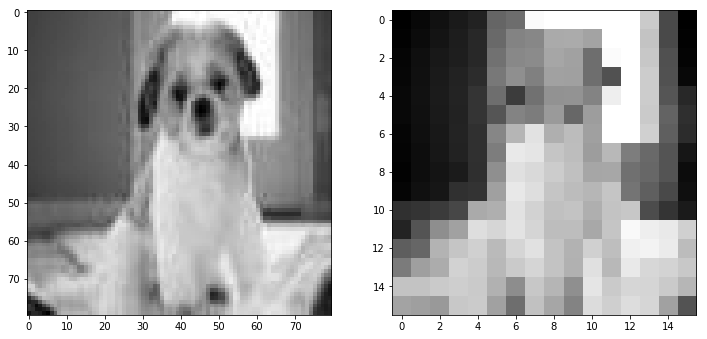

In [23]:
k_size = 5
MK = image.shape[0] // k_size
NL = image.shape[1] // k_size

image_max_pool_2 = image[:MK*k_size, :NL*k_size].reshape(MK, k_size, NL, k_size).max(axis=(1, 3))
fig,((a,b)) = plt.subplots(1,2, figsize=(12,12))

a.imshow(image, cmap="gray")
b.imshow(image_max_pool_2, cmap="gray")


#### Implementation of maxpooling in tensorflow

In [24]:
tf.reset_default_graph()
_x = np.array([image[:, :, np.newaxis].astype(np.float32)])
x = tf.get_variable('X', initializer=_x)
pool1 = tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding="VALID")
result = None

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    result = sess.run(pool1)

print("image after pooling", result.shape)

image after pooling (1, 39, 39, 1)


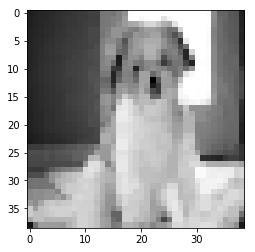

In [25]:
plt.imshow(result[0, :, :, 0], cmap="gray")

#### StandardNetworks vs ConvNetworks

In the previous cells it was shown how the convolutions and the subsampling of images work, it showed how to use them in tensorflow. In what remains of the notebook the following will be shown:

    1. Build, train and test a standard network to classify sign language
    2. Build, train and test a ConvNet network to classify sign language
    3. Use a ConvNet with LeNet-5 architecture to classify when an image has a human face or not

### Sign language
<img src="https://upload.wikimedia.org/wikipedia/commons/2/21/Lengua_de_Signos_%28Bonet%2C_1620%29_B%2C_C%2C_D.jpg" width="180px">

In the next cells we will use a network to classify sign language. The input of the network is an image of a hand making a signal and the output of the network is a letter of the alphabet that corresponds to that signal made by the hand.

##### Datos

The data for this experiment is a subset of the dataset that can be found in [Kaggle - Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist)

##### Conocimiento previo

In [Notebook 1](notebook2.ipynb) 
tools such as pandas, scikit-learn and tensorflow were used to define networks and the following steps were carried out:

1. Prepare the data in a training set and another test
2. Define the variables and operations of the network
3. Define the learning operations of the network
4. Initialize the network in a tensorflow session
5. Train the network with learning operations during (n) seasons
6. Measure the accuracy of the network and test the network

In [26]:
sing_hand_data = pd.read_csv('./data/hands_signs.csv', index_col=None)

In [27]:
print(sing_hand_data['letter'].unique().tolist())

['H', 'G', 'F', 'S', 'T', 'R', 'V', 'U', 'M', 'E', 'P', 'X', 'D', 'L', 'C', 'W', 'I', 'N', 'Q', 'Y', 'A', 'K', 'O', 'B']


In [28]:
sing_hand_data['label'] = LabelEncoder().fit_transform(sing_hand_data['letter'])

In [29]:
sing_hand_data.head(5)

,letter,path,label
0,H,./data/sign-language-mnist/H/12449.jpg,7
1,G,./data/sign-language-mnist/G/6771.jpg,6
2,F,./data/sign-language-mnist/F/19938.jpg,5
3,S,./data/sign-language-mnist/S/23951.jpg,17
4,H,./data/sign-language-mnist/H/8871.jpg,7


In [30]:
x_train, x_test, y_train, y_test = train_test_split(sing_hand_data['path'], sing_hand_data['label'], test_size=0.2)

In [31]:
im = cv2.imread(sing_hand_data["path"][36], 0)
print("Letter: ", sing_hand_data["letter"][36])


Letter:  C


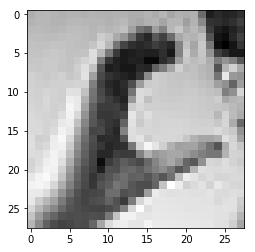

In [32]:
plt.imshow(im, cmap="gray")

In [33]:
#helper functions
def get_images(images_path, newaxis=False):
    images = []
    for path in images_path:
        if newaxis:
            im = cv2.imread(path, 0)[:, :, np.newaxis].astype(np.float32)
        else:
            im = cv2.imread(path, 0)
        images.append(im)

    return np.array(images)

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy_ = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy_ * len(batch_x))
    return total_accuracy / num_examples

signs_labels = [chr(i) for i in range(ord('A'), ord('Z')+1)]

### Red estándar

In [34]:
tf.reset_default_graph()
tf.set_random_seed(1)

x = tf.placeholder(tf.float32, (None, 28,28), name="X") 
y = tf.placeholder(tf.int32, (None), name="Y")
y_one_hot = tf.one_hot(y, 24)

# parameters layer 1
_x = flatten(x)
b1 = tf.get_variable("b1", initializer = np.zeros(392, dtype=np.float32))
W1 = tf.get_variable("W1", (392, 784), initializer = tf.truncated_normal_initializer())
Z1 = tf.add(tf.tensordot(_x, tf.transpose(W1), [[1], [0]]), b1)
A1 = tf.nn.relu(Z1)

# parameters layer 2
b2  = tf.get_variable("b2", initializer = np.zeros(196, dtype=np.float32))
W2 = tf.get_variable("W2", (196, 392), initializer = tf.truncated_normal_initializer())
Z2 = tf.add(tf.tensordot(A1, tf.transpose(W2), [[1], [0]]), b2)
A2 = tf.nn.relu(Z2)

# parameters output layer
W_l = tf.get_variable("W_l", (24, 196), initializer=tf.truncated_normal_initializer())
b_l = tf.get_variable("b_l", initializer=np.zeros(24, dtype=np.float32))

logits = tf.add(tf.tensordot(A2, W_l, [[1], [1]]), b_l)

# trainning
entropy   = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_one_hot)
loss      = tf.reduce_mean(entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train     = optimizer.minimize(loss)
correct   = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
accuracy  = tf.reduce_mean(tf.cast(correct, tf.float32))
saver = tf.train.Saver()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [35]:
BATCH_SIZE = 64
EPOCHS = 21
EVALUATE_EVERY_N_EPOCHS = 5

writer = tf.summary.FileWriter('./graph', tf.get_default_graph())
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)
    
    t0 = time.time()
    for epoch in range(EPOCHS):

        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = get_images(x_train[offset:end]), y_train[offset:end]
            sess.run(train, feed_dict={x: batch_x, y: batch_y})

        if (epoch % EVALUATE_EVERY_N_EPOCHS) == 0:
            train_accuracy = evaluate(get_images(x_train), y_train)
            validation_accuracy = evaluate(get_images(x_test), y_test)
            fortmat_string = "EPOCH({})\t -> Train Accuracy = {:.3f} | Validation Accuracy = {:.3f}"
            print(fortmat_string.format(epoch, train_accuracy, validation_accuracy))
    t1 = time.time()
    total = t1-t0
    print("trainning elapsed time", round(total, 2), "seconds")
    saver.save(sess, './networks_std')
writer.close()

EPOCH(0)	 -> Train Accuracy = 0.212 | Validation Accuracy = 0.216
EPOCH(5)	 -> Train Accuracy = 0.693 | Validation Accuracy = 0.660
EPOCH(10)	 -> Train Accuracy = 0.868 | Validation Accuracy = 0.828
EPOCH(15)	 -> Train Accuracy = 0.927 | Validation Accuracy = 0.892
EPOCH(20)	 -> Train Accuracy = 0.938 | Validation Accuracy = 0.919
trainning elapsed time 39.49 seconds


### Predicción

En la siguiente celda se probara el modelo sobre nuevos imagenes

In [27]:
signs_images_path = glob.glob("./images/signs/*.png")
signs_images = [cv2.resize(im, (28,28)) for im in get_images(signs_images_path)]

In [28]:
preds = None
logs  = None
pred_labels = None
with tf.Session() as sess:
    saver.restore(sess, './networks_std')
    prediction = tf.nn.softmax(logits)
    preds, logs = sess.run([prediction, logits], feed_dict={ x: signs_images })
    pred_labels = np.argmax(preds, axis=1)



INFO:tensorflow:Restoring parameters from ./networks_std


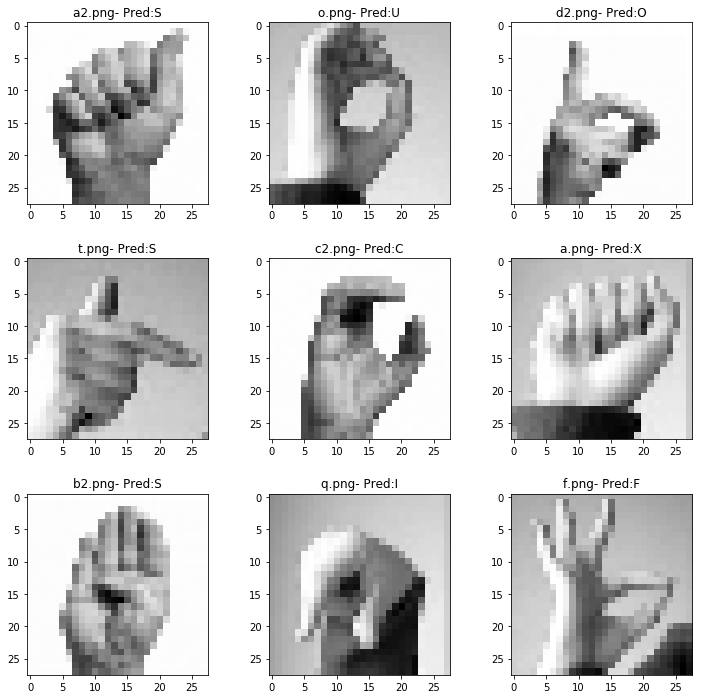

In [29]:
fig, draws = plt.subplots(3,3, figsize=(12,12))
draws = draws.reshape(-1)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for idx in range(9):
    draws[idx].set_title(signs_images_path[idx].split("/")[-1] + "- Pred:" + signs_labels[pred_labels[idx]])
    im =  cv2.resize(signs_images[idx], (28,28))
    draws[idx].imshow(im, cmap="gray")


In [30]:
np.argmax(logs, axis=1)

array([18, 20, 14, 18,  2, 23, 18,  8,  5])

In [31]:
signs_labels[8]

'I'

#### Number of parameters

Now we are going to calculate the number of parameters of the network of signs for this we will use the parameters W's and b's
with the `get_shape` and` as_list` method this returns a list with the dimensions of that parameter
example:

`W1.get_shape (). As_list ()` returns `[392, 784]` let's create a method to extract the total number of parameters
of the network passing a list of the variables that represent these parameters that are W's and b's

In [32]:
def get_total_params(params_list):
    total_params = 0
    for param in params_list:
        param_dim = param.get_shape().as_list()
        
        total_param_dimension = 1
        for num in param_dim:
            total_param_dimension = total_param_dimension * num
            
        total_params = total_params + total_param_dimension
        
    return [total_params, '{:,}'.format(total_params)]


In [33]:
param_numbers = get_total_params([W1, b1, W2, b2, W_l, b_l])
param_numbers

[389476, '389,476']

In [34]:
mark_text = "#### Standard Network Total Parameters = {} ".format(param_numbers[1])
display(Markdown(mark_text))

#### Standard Network Total Parameters = 389,476 

### ConvNet

In [35]:
tf.reset_default_graph()
tf.set_random_seed(1)

x = tf.placeholder(tf.float32, (None, 28,28, 1), name="X") 
y = tf.placeholder(tf.int32, (None), name="Y")
y_one_hot = tf.one_hot(y, 24)

# parameters layer 1
b1 = tf.get_variable("b1", initializer = np.zeros(16, dtype=np.float32))
W1 = tf.get_variable("W1", (8, 8, 1, 16), initializer = tf.truncated_normal_initializer())
Z1 = tf.nn.conv2d(x, W1, strides=[1, 3, 3, 1], padding='VALID') + b1
A1 = tf.nn.relu(Z1)

b2_ = tf.get_variable("b2_", initializer = np.zeros(32, dtype=np.float32))
W2_ = tf.get_variable("W2_", (4, 4, 16, 32), initializer = tf.truncated_normal_initializer())
Z2_ = tf.nn.conv2d(A1, W2_, strides=[1, 3, 3, 1], padding='VALID') + b2_
A2_ = flatten(tf.nn.relu(Z1))


# parameters layer 2
W2 = tf.get_variable("W2", (784, 196), initializer = tf.truncated_normal_initializer())
b2  = tf.get_variable("b2", initializer = np.zeros(196, dtype=np.float32))
Z2 = tf.add(tf.tensordot(A2_, W2, [[1], [0]]), b2)
A2 = tf.nn.relu(Z2)

# parameters output layer
W_l = tf.get_variable("W_l", (196, 24), initializer=tf.truncated_normal_initializer())
b_l = tf.get_variable("b_l", initializer=np.zeros(24, dtype=np.float32))

logits = tf.add(tf.tensordot(A2, W_l, [[1], [0]]), b_l)

# trainning
entropy   = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_one_hot)
loss      = tf.reduce_mean(entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train     = optimizer.minimize(loss)
correct   = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
accuracy  = tf.reduce_mean(tf.cast(correct, tf.float32))

saver = tf.train.Saver()

In [37]:
BATCH_SIZE = 64
EPOCHS = 21
EVALUATE_EVERY_N_EPOCHS = 5 # epochs

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)

    t0 = time.time()
    for epoch in range(EPOCHS):

        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = get_images(x_train[offset:end], newaxis=True), y_train[offset:end]
            sess.run(train, feed_dict={x: batch_x, y: batch_y})

        if (epoch % EVALUATE_EVERY_N_EPOCHS) == 0:
            train_accuracy = evaluate(get_images(x_train, newaxis=True), y_train)
            validation_accuracy = evaluate(get_images(x_test, newaxis=True), y_test)
            fortmat_string = "EPOCH({})\t -> Train Accuracy = {:.3f} | Validation Accuracy = {:.3f}"
            print(fortmat_string.format(epoch, train_accuracy, validation_accuracy))
    t1 = time.time()
    total = t1-t0
    print("trainning elapsed time", round(total, 2), "seconds")
    saver.save(sess, './networks_conv_v1')

EPOCH(0)	 -> Train Accuracy = 0.091 | Validation Accuracy = 0.092
EPOCH(5)	 -> Train Accuracy = 0.599 | Validation Accuracy = 0.548
EPOCH(10)	 -> Train Accuracy = 0.882 | Validation Accuracy = 0.833
EPOCH(15)	 -> Train Accuracy = 0.956 | Validation Accuracy = 0.905
EPOCH(20)	 -> Train Accuracy = 0.983 | Validation Accuracy = 0.938
trainning elapsed time 38.09 seconds


### prediction

In [38]:
preds = None
logs  = None
pred_labels = None
with tf.Session() as sess:
    saver.restore(sess, './networks_conv_v1')
    prediction = tf.nn.softmax(logits)
    preds, logs = sess.run([prediction, logits], feed_dict={ x: [x_[:,:, np.newaxis] for x_ in signs_images] })
    pred_labels = np.argmax(preds, axis=1)



INFO:tensorflow:Restoring parameters from ./networks_conv_v1


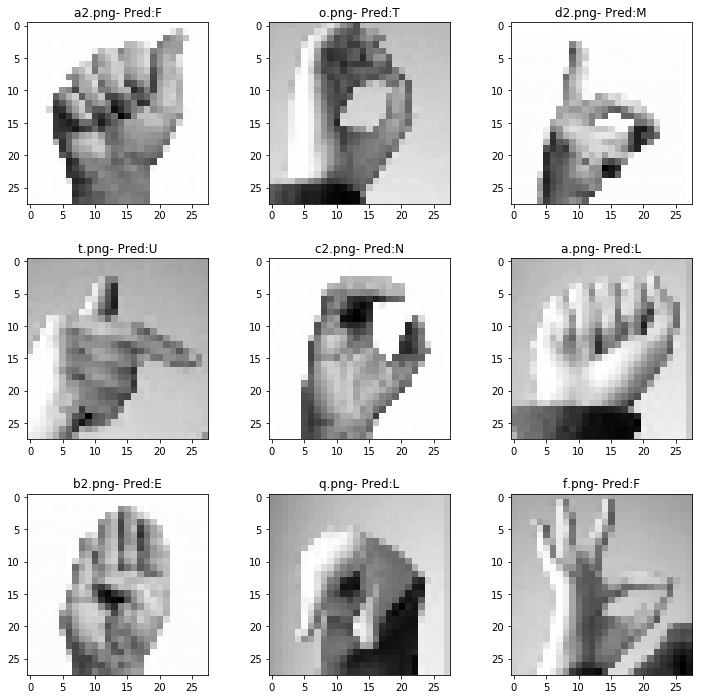

In [39]:
fig, draws = plt.subplots(3,3, figsize=(12,12))
draws = draws.reshape(-1)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for idx in range(9):
    draws[idx].set_title(signs_images_path[idx].split("/")[-1] + "- Pred:" + signs_labels[pred_labels[idx]])
    im =  cv2.resize(signs_images[idx], (28,28))
    draws[idx].imshow(im, cmap="gray")


In [40]:
param_numbers = get_total_params([W1, b1, W2_, b2_, W2, b2, W_l, b_l])
param_numbers

[167852, '167,852']

In [41]:
mark_text = "#### ConvNet Total Parameters = {} ".format(param_numbers[1])
display(Markdown(mark_text))

#### ConvNet Total Parameters = 167,852 

### LeNet-5 Architecture

<img src="https://moisesvw.github.io/img/lenet-5.png">
fuente: [Yan LeCun](http://yann.lecun.com/exdb/lenet/)

The structure of this network is the following:
- 32x32 pixels input image
- Convolution 1 kernel (5, 5), 6 filters
- Subsampling with Maxpooling kernel (2,2), slides (2,2)
- Convolution 2 kernel (5, 5), 16 filters
- Subsampling with Maxpooling kernel (2,2), slides (2,2)
- standard network 120
- standard network 84
- exit 10 (softmax)

This exercise uses a subset of the original data that can be found in these links
- http://vis-www.cs.umass.edu/lfw
- https://www.kaggle.com/slothkong/10-monkey-species/data
- http://vision.stanford.edu/aditya86/ImageNetDogs/



#### Preparación de datos

In [42]:
images_path = glob.glob("./data/faces/**/*.jpg")
labels = { 'faces': 1, 'no_faces': 0 }
data = pd.DataFrame([ {'path': x, 'label': labels[x.split("/")[-2]]} for x in images_path]).sample(4000)

In [43]:
data.head()

,label,path
3933,1,./data/faces/faces/Koichiro_Matsuura_0001.jpg
1805,0,./data/faces/no_faces/n02105056_143.jpg
410,0,./data/faces/no_faces/n02088632_610.jpg
1830,0,./data/faces/no_faces/n02105251_7127.jpg
635,0,./data/faces/no_faces/n02102480_8269.jpg


In [44]:
data.groupby('label').count()

,path
label,
0,2000
1,2000


In [45]:
x_train, x_test, y_train, y_test = train_test_split(data['path'], data['label'], test_size=0.1)

#### Modelo

In [46]:
tf.reset_default_graph()
tf.set_random_seed(1)

x = tf.placeholder(tf.float32, (None, 80,80, 1), name="X") 
y = tf.placeholder(tf.int32, (None), name="Y")
y_one_hot = tf.one_hot(y, 2)

# parameters layer 1
W1 = tf.get_variable("W1", (5, 5, 1, 6), initializer = tf.truncated_normal_initializer())
b1 = tf.get_variable("b1", initializer = np.zeros(6, dtype=np.float32))
Z1 = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID') + b1
A1 = tf.nn.relu(Z1)
A1max_pool = tf.nn.max_pool(A1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

# parameters layer 2
W2 = tf.get_variable("W2", (5, 5, 6, 16), initializer = tf.truncated_normal_initializer())
b2 = tf.get_variable("b2", initializer = np.zeros(16, dtype=np.float32))
Z2 = tf.nn.conv2d(A1max_pool, W2, strides=[1, 1, 1, 1], padding='VALID') + b2
A2 = tf.nn.relu(Z2)
A2max_pool = tf.nn.max_pool(A2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
A2flat = flatten(A2max_pool)

# parameters layer 3
W3 = tf.get_variable("W3", (4624, 120), initializer = tf.truncated_normal_initializer())
b3 = tf.get_variable("b3", initializer = np.zeros(120, dtype=np.float32))
Z3 = tf.add(tf.tensordot(A2flat, W3, [[1], [0]]), b3)
A3 = tf.nn.relu(Z3)

# parameters layer 4
W4 = tf.get_variable("W4", (120, 84), initializer = tf.truncated_normal_initializer())
b4  = tf.get_variable("b4", initializer = np.zeros(84, dtype=np.float32))
Z4 = tf.add(tf.tensordot(A3, W4, [[1], [0]]), b4)
A4 = tf.nn.relu(Z4)

# parameters output layer
W_l = tf.get_variable("W_l", (84, 2), initializer=tf.truncated_normal_initializer())
b_l = tf.get_variable("b_l", initializer=np.zeros(2, dtype=np.float32))

logits = tf.add(tf.tensordot(A4, W_l, [[1], [0]]), b_l)

# trainning
entropy   = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y_one_hot)
loss      = tf.reduce_mean(entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train     = optimizer.minimize(loss)
correct   = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
accuracy  = tf.reduce_mean(tf.cast(correct, tf.float32))

saver = tf.train.Saver()

In [48]:
BATCH_SIZE = 64
EPOCHS = 5
EVALUATE_EVERY_N_EPOCHS = 5 # epochs

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)

    t0 = time.time()
    for epoch in range(EPOCHS):

        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = get_images(x_train[offset:end], newaxis=True), y_train[offset:end]

            sess.run(train, feed_dict={x: batch_x, y: batch_y})

        if (epoch % EVALUATE_EVERY_N_EPOCHS) == 0:
            train_accuracy = evaluate(get_images(x_train, newaxis=True), y_train)
            validation_accuracy = evaluate(get_images(x_test, newaxis=True), y_test)
            fortmat_string = "EPOCH({})\t -> Train Accuracy = {:.3f} | Validation Accuracy = {:.3f}"
            print(fortmat_string.format(epoch, train_accuracy, validation_accuracy))
    t1 = time.time()
    total = t1-t0
    print("trainning elapsed time", round(total, 2), "seconds")
    saver.save(sess, './lenet-5')

EPOCH(0)	 -> Train Accuracy = 0.712 | Validation Accuracy = 0.755
trainning elapsed time 44.34 seconds


### prediccion

In [49]:
test_images = [ cv2.resize(x, (80,80)) for x in get_images(glob.glob("./images/faces/*.jpg")) ]


In [50]:
preds = None
logs  = None
pred_labels = None
with tf.Session() as sess:
    saver.restore(sess, './lenet-5')
    prediction = tf.nn.softmax(logits)
    preds, logs = sess.run([prediction, logits], feed_dict={ x: [x_[:,:, np.newaxis] for x_ in test_images] })
    pred_labels = np.argmax(logs, axis=1)


INFO:tensorflow:Restoring parameters from ./lenet-5


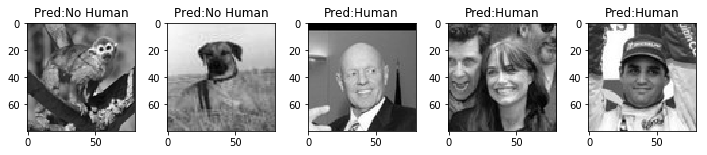

In [51]:
labels = { 1: "Human", 0: "No Human" }
fig, draws = plt.subplots(1,5, figsize=(12,12))
draws = draws.reshape(-1)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for idx in range(len(pred_labels)):
    draws[idx].set_title("Pred:" + labels[pred_labels[idx]])
    im =  test_images[idx]
    draws[idx].imshow(im, cmap="gray")